In [1]:
from pyforestscan.calculate import calculate_chm, calculate_fhd, assign_voxels
from pyforestscan.handlers import read_lidar, create_geotiff
import numpy as np
import glob, os

In [2]:
path = "/home/mgallet/Documents/DATA/LIDAR_TEST/processed_V4_fulltiles_avecCSF_002VOX/**/*.npy"
path2 = "/home/mgallet/Documents/DATA/LIDAR_TEST/processed_V2_*/**/*.npy"

In [29]:
data = np.load(glob.glob(path2, recursive=True)[0])

In [32]:
data = np.load("testmerged.npy")
data

array([(1001061.01, 6550936.65, 2694.73, 1122, 2, 0.),
       (1001061.5 , 6550936.26, 2694.52, 1555, 2, 0.),
       (1001060.83, 6550935.2 , 2692.85, 1596, 2, 0.), ...,
       (1001558.33, 6550865.1 , 2394.27, 1018, 2, 0.),
       (1001557.88, 6550865.46, 2394.4 , 1156, 2, 0.),
       (1001557.23, 6550865.98, 2395.09, 1057, 2, 0.)],
      shape=(7864149,), dtype=[('X', '<f8'), ('Y', '<f8'), ('Z', '<f8'), ('Intensity', '<u2'), ('Classification', 'u1'), ('HeightAboveGround', '<f8')])

In [ ]:
voxel_resolution = (20, 20, 0.1)
# voxels, extent = assign_voxels(pipeline.arrays[0], voxel_resolution)

chm = calculate_chm(data, voxel_resolution, interpolation=None)



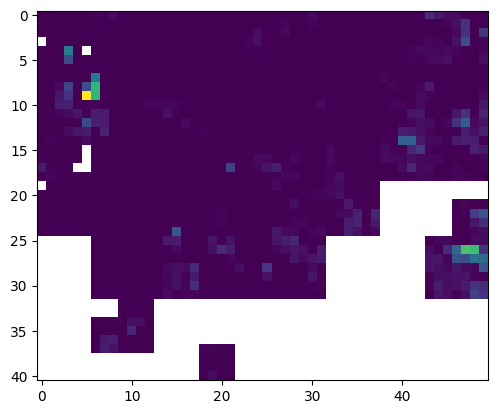

In [18]:
from matplotlib import pyplot as plt
plt.imshow(chm[0], cmap="viridis")

In [ ]:
# create_geotiff(chm[0], "DATA/LIDAR/test/test/chm.tif", "EPSG:2154", extent)


In [76]:
import json
with open("/home/mgallet/Documents/Herbiland/PACKAGE/lidar_processing/config/default_config.json") as f:
    d = json.load(f)
# d=json.loads("/home/mgallet/Documents/Herbiland/PACKAGE/lidar_processing/config/default_config.json")
d

{'processor_settings': {'group': -1,
  'keep_variables': ['X',
   'Y',
   'Z',
   'Intensity',
   'Classification',
   'HeightAboveGround'],
  'n_jobs': 1},
 'pdal_pipeline': {'phase_1': [{'type': 'filters.elm'},
   {'type': 'filters.outlier',
    'method': 'statistical',
    'mean_k': 40,
    'multiplier': 1.5},
   {'type': 'filters.csf',
    'resolution': 0.75,
    'rigidness': 1,
    'iterations': 800,
    'threshold': 0.2},
   {'type': 'filters.voxeldownsize', 'cell': 0.02}],
  'phase_2': [{'type': 'filters.merge'},
   {'type': 'filters.hag_nn', 'count': 80},
   {'type': 'filters.range', 'limits': 'HeightAboveGround[0:35]'},
   {'type': 'filters.expression',
    'expression': '((Classification >= 2) && (Classification <= 5))'}]},
 'paths': {'input_path': '/home/mgallet/Documents/DATA/lidar_data',
  'output_dir': '/home/mgallet/Documents/DATA/LIDAR_TEST',
  'lidar_list_tiles': '/home/mgallet/Documents/DATA/TA_programme_LiDAR-HD/TA_programme_lidar_HD_path.shp',
  'area_of_interest': 

In [81]:
def create_pdal_pipeline_phase(input_file, output_file, pipeline=None, phase="phase_1"):
    """
    Crée ou modifie une phase du pipeline PDAL (phase_1 ou phase_2) pour traiter chaque tuile individuellement.

    Parameters:
    ----------
    input_file : str or list of str
        Chemin du fichier LAS/LAZ d'entrée ou liste de chemins.
    output_file : str
        Chemin du fichier de sortie pour la phase spécifiée.
    pipeline : dict, optional
        Pipeline PDAL existant à modifier. Si None, un nouveau pipeline est créé.
    phase : str
        Nom de la phase à traiter ('phase_1' ou 'phase_2').

    Returns:
    -------
    dict
        Configuration du pipeline PDAL pour la phase spécifiée.
    """

    if pipeline is None:
        pipeline = {}

    if phase not in pipeline:
        pipeline[phase] = []

    # Nettoyer la phase des anciens readers et writers
    pipeline[phase] = [
        p for p in pipeline[phase]
        if p.get("type") not in ["readers.las", "writers.las"]
    ]

    # Ajouter les readers
    if isinstance(input_file, str):
        pipeline[phase].insert(
            0,
            {
                "type": "readers.las",
                "filename": input_file,
                "spatialreference": "EPSG:2154",
            },
        )
    elif isinstance(input_file, list):
        for file in reversed(input_file):  # On les insère dans l'ordre d'origine
            pipeline[phase].insert(
                0,
                {
                    "type": "readers.las",
                    "filename": file,
                    "spatialreference": "EPSG:2154",
                },
            )

    # Ajouter le writer
    pipeline[phase].append(
        {
            "type": "writers.las",
            "filename": output_file,
            "compression": "false",
            "minor_version": "4",
            "forward": "all",
        }
    )

    return pipeline[phase]

create_pdal_pipeline_phase(["test.las", "yolo.mas"], "test2.las", pipeline=deepcopy(d["pdal_pipeline"]), phase="phase_2")

[{'type': 'readers.las',
  'filename': 'test.las',
  'spatialreference': 'EPSG:2154'},
 {'type': 'readers.las',
  'filename': 'yolo.mas',
  'spatialreference': 'EPSG:2154'},
 {'type': 'filters.merge'},
 {'type': 'filters.hag_nn', 'count': 80},
 {'type': 'filters.range', 'limits': 'HeightAboveGround[0:35]'},
 {'type': 'filters.expression',
  'expression': '((Classification >= 2) && (Classification <= 5))'},
 {'type': 'writers.las',
  'filename': 'test2.las',
  'compression': 'false',
  'minor_version': '4',
  'forward': 'all'}]

In [83]:
import os
os.memory()

AttributeError: module 'os' has no attribute 'memory'